# Livrable 2 - Traitement d'images

## 1. Chargement des données et constitution du jeu de données

In [1]:
%load_ext tensorboard

import os
import PIL
import pathlib
import time
from datetime import datetime
from packaging import version

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import keras_tuner as kt
import tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

In [2]:
folder = pathlib.Path().resolve()
data_dir = str(folder / "data/Photo")

In [9]:
IMG_SIZE          = 600                # taille coté final d'une image en pixel (ici 28x28)
NB_EPOCHS_DENOISE = 50              # nombre epoch alogithme debruiter
BATCH_SIZE        = 32               # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser.h5"     # sauvegarde du modele de debruitage
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'))

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

10000
8000
2000


In [4]:
path = pathlib.Path("data/Photo")
X = ['data/Photo/'+f for f in os.listdir(path)]

In [5]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = tf.image.resize(array, [IMG_SIZE, IMG_SIZE])
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    print(indices)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def show(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

In [10]:
from keras.preprocessing import image

x = []
for path in X[:NUM_IMAGES]:
    img = image.load_img(path)
    array = image.img_to_array(img)
    array = preprocess(array)
    x.append(array)

x = np.array(x)

In [11]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val = train_test_split(x[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(X_val)

(800, 200)

[213  75 646 118 617 150 444 694 606 363]


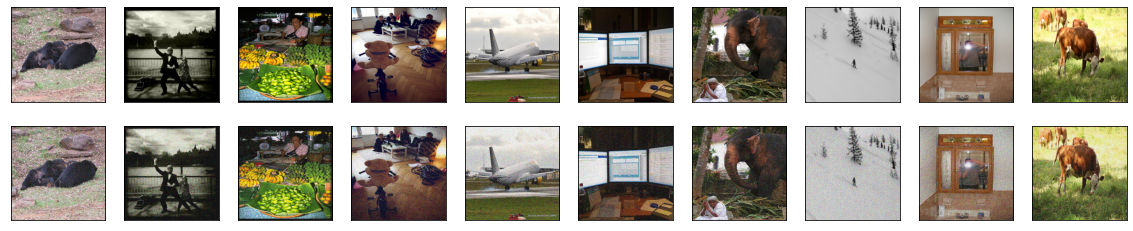

In [12]:
noisy_train_data = noise(X_train)
noisy_test_data = noise(X_val)

display(X_train, noisy_train_data)

In [16]:
input = layers.Input(shape=(600, 600, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = keras.Model(input, x)
autoencoder.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600, 600, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 600, 600, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 300, 300, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 300, 300, 32)     9248

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    keras.callbacks.ModelCheckpoint("autoencoder/save_at_{epoch}.h5"),
    tf.keras.callbacks.TensorBoard(log_dir='l2/')
]

In [18]:
# Train the model
history = autoencoder.fit(
    x=noisy_train_data,
    y=X_train,
    epochs=NB_EPOCHS_DENOISE,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    shuffle=True,
    validation_data=(noisy_test_data, X_val),
)

KeyboardInterrupt: 

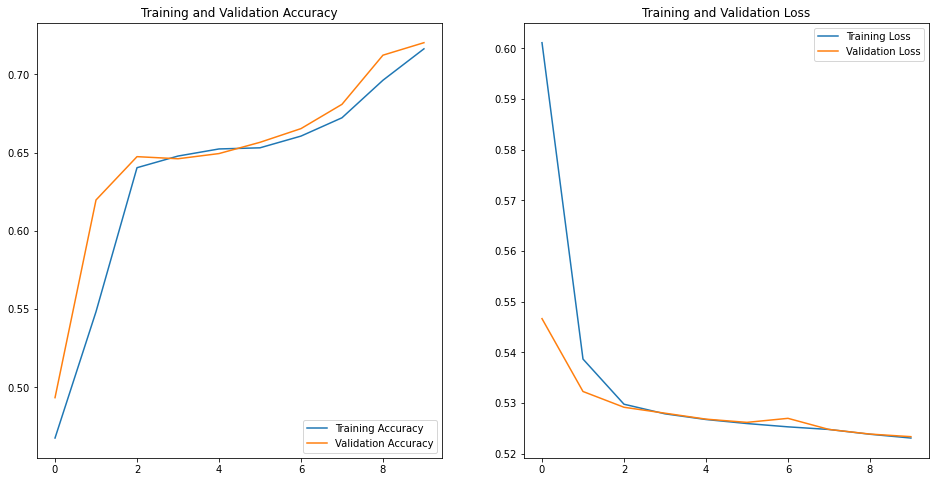

In [17]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# save the model
autoencoder.save(SAV_MODEL_DENOISE)

In [20]:
decoded_imgs = autoencoder.predict(noisy_test_data)

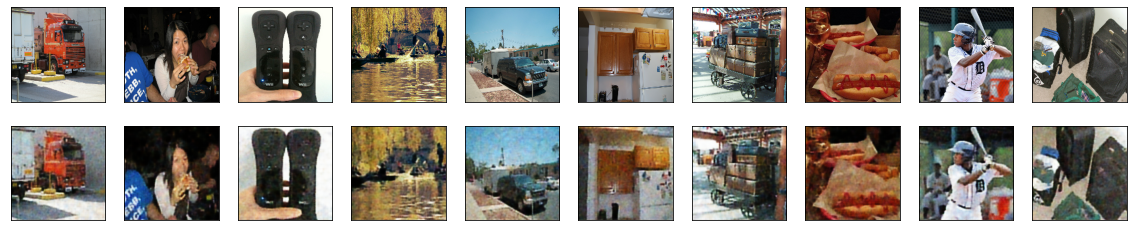

In [22]:
display(test_data, decoded_imgs)